In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 32.4601180553s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.60543704033s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.193248987198s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

In [10]:
# regr_fits = pd.read_csv('./data_sharing/regr_fits_final.csv', index_col=0)

In [11]:
def figure_styles():

    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')

figure_styles()

# Fitting linear epistasis model

In [12]:
from sklearn.linear_model import LinearRegression, TheilSenRegressor

def get_model(first, second, double, variable_genes, matrix):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)
    
    X = singles_expr
    y = double_expr
    ts.fit(X, y.ravel())
    
    return ts

def get_model_predictions(first, second, double, variable_genes):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    regr = LinearRegression(fit_intercept=False)
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)    
    X = singles_expr
    y = double_expr
    regr.fit(X, y)
    ts.fit(X, y.ravel())
    Z = regr.predict(X)
    Zts = ts.predict(X)
    
    out['name'] = double
    out['pred'] = pd.Series(Z.flatten(), index=variable_genes, name=double)
    out['ts_pred'] = pd.Series(Zts.flatten(), index=variable_genes, name=double)
    out['first_expr'] = pd.Series(first_expr.flatten(), index=variable_genes, name=double)
    out['second_expr'] = pd.Series(second_expr.flatten(), index=variable_genes, name=double)
    out['double_expr'] = pd.Series(double_expr.flatten(), index=variable_genes, name=double)

    return out

In [13]:
ks, ps, adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.5',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   15.5s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   20.1s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   25.0s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   34.4s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   44.5s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   51.5s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   58.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.3min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.7min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  2.0min remainin

Choose genes that are used for fitting linear model ("abundant" genes = mean expression > 0.5). We then only fit the model to perturbations where doubly perturbed cells have at least 10 differentially expressed genes abundant genes.

In [14]:
perturbation_ids = pop.gene_ids(np.union1d(mean_pop.cells['first_target'], mean_pop.cells['second_target']))
abundant_genes = np.setdiff1d(pop.genes.query('mean > 0.5').index.values, perturbation_ids)

doubles = list()
for idx, row in mean_pop.cells.loc[perturbations].query('num_targets == 2').iterrows():
    first = row['first_target'] + '_NegCtrl0'
    second = 'NegCtrl0_' + row['second_target']
    if (first in mean_pop.cells.index) and (second in mean_pop.cells.index):
        doubles.append((first, second, idx))

# only fit when double has more than 10 differentially expressed genes (very permissive)
# this will incidentally remove BCL2L11 and BAK1 doubles which we know are broken
gene_lists = [(first, second, double, abundant_genes) for first, second, double in doubles
               if ((adj_ps[double] < 0.001).sum() > 10)]

Regenerate linear epistasis model predictions

In [15]:
from joblib import Parallel, delayed

matrix = mean_pop.normalized_matrix

pred_data = Parallel(n_jobs=24, verbose=10)(delayed(get_model_predictions)(*double) for double in gene_lists)

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:   13.8s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:   14.5s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   15.0s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   28.2s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   39.9s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   41.3s
[Parallel(n_jobs=24)]: Done  91 out of 125 | elapsed:   54.3s remaining:   20.3s
[Parallel(n_jobs=24)]: Done 104 out of 125 | elapsed:  1.1min remaining:   13.0s
[Parallel(n_jobs=24)]: Done 117 out of 125 | elapsed:  1.1min remaining:    4.6s
[Parallel(n_jobs=24)]: Done 125 out of 125 | elapsed:  1.3min finished


Global variables used by some of the plotting routines below

In [16]:
preds = pd.DataFrame([pred['pred'] for pred in pred_data])
ts_preds = pd.DataFrame([pred['ts_pred'] for pred in pred_data])
first_exprs = pd.DataFrame([pred['first_expr'] for pred in pred_data])
second_exprs = pd.DataFrame([pred['second_expr'] for pred in pred_data])
double_exprs = pd.DataFrame([pred['double_expr'] for pred in pred_data])

# Plotting routines for comparing expression in singles and double

In [17]:
from dcor import distance_correlation

def compare_singles_to_double(double, limits=[-2, 2], figsize=[3, 3], plot_perfect=False):
    first, second = double.split('_')

    plt.figure(figsize=figsize)
    plt.axis('equal')
    s1 = plt.scatter(first_exprs.loc[double],
                     double_exprs.loc[double],
                     s=10, alpha=0.3, color='#566573')
    s2 = plt.scatter(second_exprs.loc[double],
                     double_exprs.loc[double],
                     s=10, alpha=0.3)
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    if plot_perfect:
        l, = plt.plot(np.asarray(limits), 2.*np.asarray(limits), color='grey', zorder=0, ls='--')
    plt.xlim(limits)
    plt.ylim(limits)
    
    if plot_perfect:
        plt.legend([s1, s2, l], [first, second, 'perfect additive'])
    else:
        plt.legend([s1, s2], [first, second])

    plt.xlabel('single')
    plt.ylabel(' / '.join(double.split('_')) + ' double')
    plt.title(' / '.join(double.split('_')))
    
def compare_double_to_model(double, limits=[-2,2], model_type='ts', figsize=[3,3], s=5):
    first, second = double.split('_')

    if model_type == 'ts':
        pred = ts_preds.loc[double]
    elif model_type == 'regression':
        pred = preds.loc[double]  
    elif model_type == 'additive':
        pred = first_exprs.loc[double] + second_exprs.loc[double]
    
    plt.figure(figsize=figsize)
    plt.axis('equal')
    s1 = plt.scatter(pred,
                     double_exprs.loc[double],
                     s=s, alpha=0.3, color='#566573')
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    plt.xlim(limits)
    plt.ylim(limits)

    plt.xlabel('c1(' + first + ') + c2(' + second + ')')
    plt.ylabel(' / '.join(double.split('_')) + ' double')
    plt.title(' / '.join(double.split('_')))
    print(pred.corr(double_exprs.loc[double]))
    print(distance_correlation(pred.values.reshape(-1, 1), double_exprs.loc[double].values.reshape(-1, 1)))
    
def compare_singles(double, limits=[-2, 2]):
    first, second = double.split('_')

    plt.figure(figsize=[3,3])
    plt.axis('equal')
    s1 = plt.scatter(first_exprs.loc[double],
                     second_exprs.loc[double],
                     s=10, alpha=0.3, color='#566573')
    plt.plot(limits, limits, color='grey', zorder=0, ls='-')
    plt.xlim(limits)
    plt.ylim(limits)

    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(' / '.join(double.split('_')))

def get_model(mean_pop, double, variable_genes):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    matrix = mean_pop.where(cells='index in @chosen_perturbations',
                            genes=variable_genes,
                            normalized=True,
                            chosen_perturbations=chosen_perturbations)
    
    singles_expr = matrix.loc[[first_id, second_id], variable_genes].T.values
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)
    
    X = singles_expr
    y = double_expr
    ts.fit(X, y.ravel())
    
    return ts

def double_predicted_expression(mean_pop, double, genes, model_fit_genes, additive_model=False, include_difference=True):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    mean_expr = mean_pop.where(cells=chosen_perturbations,
                          genes=genes,
                          normalized=True,
                          gene_names=True)
    
    if additive_model:
        mean_expr.loc['additive prediction'] = mean_expr.loc[first_id] + mean_expr.loc[second_id]
        if include_difference:
            mean_expr.loc['difference'] = mean_expr.loc[double] - mean_expr.loc['additive prediction']
    else:
        ts = get_model(mean_pop, double, model_fit_genes)
        mean_expr.loc['model prediction'] = pd.Series(ts.predict(mean_expr.loc[[first_id, second_id]].T),
                                        index=mean_expr.columns)
        if include_difference:
            mean_expr.loc['difference'] = mean_expr.loc[double] - mean_expr.loc['model prediction']
    
    return mean_expr

def double_subpop(pop, double, balance_representation=True, include_control_cells=False):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second
    chosen_perturbations = [first_id, second_id, double]
    
    if balance_representation:
        min_cell_number = mean_pop.cells.query('guide_target in @chosen_perturbations')['num_cells'].min()
        first_cells = pop.cells.query('guide_target == @first_id').sample(n=min_cell_number, replace=False, random_state=100).index
        second_cells = pop.cells.query('guide_target == @second_id').sample(n=min_cell_number, replace=False, random_state=100).index
        double_cells = pop.cells.query('guide_target == @double').sample(n=min_cell_number, replace=False, random_state=100).index
        if include_control_cells:
            control_cells = control_pop.cells.sample(n=min_cell_number, replace=False, random_state=100).index
        else:
            control_cells = []
        chosen_cells = reduce(np.union1d, [first_cells, second_cells, double_cells, control_cells])
    else:
        chosen_cells = pop.cells.query('guide_target in @chosen_perturbations').index
        
    subpop = pop.subpopulation(cells='index in @chosen_cells',
                           normalized_matrix='inherit',
                           chosen_cells=chosen_cells)
    return subpop

def double_variable_expression(pop, double, test_genes, model_fit_genes, num_features=100, balance_representation=True, include_difference=True, additive_model=False, include_control_cells=False):
    first, second = double.split('_')
    
    subpop = double_subpop(pop, double, balance_representation=balance_representation, include_control_cells=include_control_cells)
    
    control_targets = control_pop.cells['guide_target'].unique()
    subpop.cells['perturbation'] = subpop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)
    
    res = tree_selector(subpop,
                    'perturbation',
                    num_features=num_features,
                    genes=test_genes,
                    normalized=True,
                    dropna=True,
                    ignore=pop.gene_ids([first, second]),
                    clf='extra',
                    n_jobs=32,
                    random_state=100,
                    )
    
    mean_expr = double_predicted_expression(mean_pop,
                                            double,
                                            res.selected_genes,
                                            model_fit_genes,
                                            additive_model=additive_model,
                                            include_difference=include_difference)
    return mean_expr

def double_variable_expression_heatmap(pop, double, test_genes, model_fit_genes, num_features=100, include_model=True, include_difference=True, balance_representation=True, additive_model=False, figsize=[8,3], square=False, quantiles=[0.03, 0.97], vmin=None, vmax=None, col_linkage=None, include_control_cells=False):
    mean_expr = double_variable_expression(pop,
                                           double,
                                           test_genes=test_genes,
                                           model_fit_genes=model_fit_genes,
                                           num_features=num_features,
                                           balance_representation=balance_representation,
                                           additive_model=additive_model,
                                           include_control_cells=include_control_cells,
                                           include_difference=include_difference)
    
    
    if vmin is None and vmax is None:
        quantile_range = np.max(np.abs(mean_expr.stack().quantile(quantiles)))
        vmin = -quantile_range
        vmax = quantile_range
    
    if not include_model:
        mean_expr = mean_expr.iloc[0:3]
    
    mean_expr.index = mean_expr.index.str.replace('_', ' / ').str.replace('NegCtrl0', 'ctrl')
    
    if col_linkage is None:
        cg = sns.clustermap(mean_expr,
                           figsize=figsize,
                           method='ward',
                           row_cluster=False,
                           cmap=plt.cm.get_cmap('RdBu_r'),
                           vmin=vmin, vmax=vmax,
                           square=square,
                           xticklabels=True)
    else:
        cg = sns.clustermap(mean_expr,
                           figsize=figsize,
                           col_linkage=col_linkage,
                           row_cluster=False,
                           cmap=plt.cm.get_cmap('RdBu_r'),
                           vmin=vmin, vmax=vmax,
                           square=square,
                           xticklabels=True)
    return mean_expr, cg

from umap import UMAP

def double_umap(pop, double, genes, num_features=100, balance_representation=True, figsize=[3,3], metric='correlation', include_control_cells=False, use_pca=False, s=10):
    first, second = double.split('_')
    first_id = first + '_NegCtrl0'
    second_id = 'NegCtrl0_' + second

    subpop = double_subpop(pop, double, include_control_cells=include_control_cells)
    control_targets = control_pop.cells['guide_target'].unique()
    subpop.cells['perturbation'] = subpop.cells['guide_target'].map(lambda x: 'control' if x in control_targets else x)

    res = tree_selector(subpop,
                'perturbation',
                num_features=num_features,
                genes=genes,
                normalized=True,
                dropna=True,
                ignore=pop.gene_ids([first, second]),
                clf='extra',
                n_jobs=32,
                random_state=100,
                )

    mapper = {first_id: 'powderblue',
             double: 'lightslategray',
             second_id: 'navy',
             'control': 'pink'}

    transformer = PCAUMAPReducer(n_neighbors=10, metric=metric, random_state=100, use_pca=use_pca)
    coords = subpop.fit_transform(transformer,
                             genes=res.selected_genes,
                             normalized=True,
                             prefix='UMAP')
    coords['perturbation'] = subpop.cells['perturbation']
    
    plt.figure(figsize=figsize)
    for perturbation in subpop.cells['perturbation'].unique():
        plt.scatter(coords.query('perturbation == "{0}"'.format(perturbation))['UMAP0'],
                coords.query('perturbation == "{0}"'.format(perturbation))['UMAP1'],
                c=mapper[perturbation], alpha=0.5, s=s, label=perturbation)
    plt.axis('off');
    plt.legend();

# CBL-CNN1 expression heatmap

Example of differentially expressed genes. Differential expression is determined by training a random forest classifier to distinguish cells from the different genetic backgrounds based on gene expression. The most informative genes for classification will naturally be reproducibly variable across conditions. The classification accuracy is a natural guage for how different cells behave across the different genetic backgrounds.

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.05)...
Using 1367 estimators for 9353 features...
Feature prediction accuracy (test size: 20.0%): 0.666666666667

               precision    recall  f1-score   support

     CBL_CNN1       0.66      0.78      0.71        58
 CBL_NegCtrl0       0.65      0.55      0.60        58
NegCtrl0_CNN1       0.70      0.58      0.63        57
      control       0.66      0.76      0.70        58

    micro avg       0.67      0.67      0.67       231
    macro avg       0.67      0.67      0.66       231
 weighted avg       0.67      0.67      0.66       231

Picked 30 features.
Using 77 estimators for 30 features...
Feature prediction accuracy (test size: 20.0%): 0.78354978355

               precision    recall  f1-score   support

     CBL_CNN1       0.82      0.69      0.75        58
 CBL_NegCtrl0       0.78      0.81      0.80        58
NegCtrl0_CNN1       0.77      0.70      0.73  

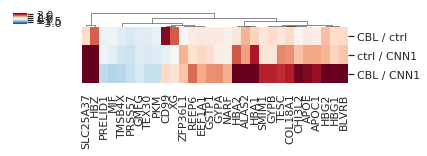

In [18]:
sns.set(font_scale=1)
_, cg = double_variable_expression_heatmap(pop,
                                           'CBL_CNN1',
                                           test_genes='mean > 0.05',
                                           model_fit_genes=abundant_genes,
                                           figsize=[6, 1.3],
                                           num_features=30,
                                           additive_model=False,
                                           include_control_cells=True,
                                           include_model=False,
                                           square=False,
                                          vmin=-4, vmax=4)
cg.savefig('./figures/double_heatmap_examples_CBL_CNN1.pdf')

# Enrichr gene set enrichment analysis

Look again for differentially expressed genes but now across all genes with mean expression > 0.05.

In [19]:
_, _, exact_adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.05',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:   24.6s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   34.0s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   46.4s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   59.5s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:  1.8min
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  2.0min
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:  2.3min
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  3.0min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  3.3min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  3.7min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  4.1min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  4.6min remainin

In [20]:
de_genes = mean_pop.where(genes=exact_adj_ps['CBL_CNN1'].sort_values().head(500).index,
                              cells=['CBL_CNN1'],
                              gene_names=True,
                              normalized=True).T['CBL_CNN1'].sort_values(ascending=False)

overexpressed = de_genes[de_genes > 0]

In [21]:
for gene in overexpressed.head(50).index:
    print gene

HBZ
SLC25A37
CNN1
HBA2
HBA1
ALAS2
HBG2
HBG1
BLVRB
CHI3L2
APOE
APOC1
COL18A1
SMIM1
GYPB
TESC
REEP6
MYL4
GYPA
GSTP1
LBH
CD7
HEMGN
EEF1A1
NARF
TMOD1
RP11-717F1.1
GYPC
FTH1
FAM210B
ASAH1
CBL
GUK1
KLF1
ZNF431
FLOT2
ZFP36L1
TCF4
CSTB
UROS
TXNIP
GYPE
FAM65C
NCOA4
RPS8
FAM83A
PRDX5
HNRNPA1
PSAP
HMBS


Above gene list was then submitted to Enrichr, with results below

In [22]:
df = pd.read_csv('./data_sharing/ARCHS4_Tissues_table.txt', header=[0], sep='\t')

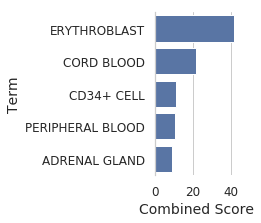

In [23]:
figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="b")
plt.xticks([0, 20, 40])
sns.despine(right=True, bottom=True)
plt.savefig('./figures/CBL_CNN1_tissue.pdf', bbox_inches='tight')

# CBL-CNN1 UMAP projection

Again uses random forest classifier. Selects 200 genes with mean expression > 0.5 (i.e. the "abundant genes" used to fit the model) that vary across conditions...

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 753 estimators for 2836 features...
Feature prediction accuracy (test size: 20.0%): 0.69696969697

               precision    recall  f1-score   support

     CBL_CNN1       0.69      0.79      0.74        58
 CBL_NegCtrl0       0.67      0.59      0.62        58
NegCtrl0_CNN1       0.79      0.60      0.68        57
      control       0.67      0.81      0.73        58

    micro avg       0.70      0.70      0.70       231
    macro avg       0.70      0.70      0.69       231
 weighted avg       0.70      0.70      0.69       231

Picked 200 features.
Using 200 estimators for 200 features...
Feature prediction accuracy (test size: 20.0%): 0.792207792208

               precision    recall  f1-score   support

     CBL_CNN1       0.84      0.79      0.81        58
 CBL_NegCtrl0       0.78      0.78      0.78        58
NegCtrl0_CNN1       0.75      0.67      0.70 

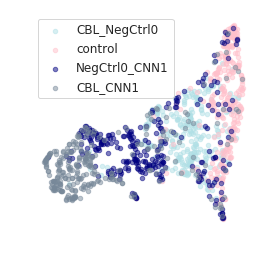

In [24]:
double_umap(pop,
            'CBL_CNN1',
            genes='mean > 0.5',
            num_features=200,
            metric='euclidean',
            include_control_cells=True,
            use_pca=True,
            figsize=[4, 4],
            s=20)
plt.savefig('./figures/cbl_cnn1_example_umap.pdf', bbox_inches='tight')

# Other CBL-CNN1 experiments

In [25]:
cdna_expr_data = pd.read_excel('./data_sharing/K562 D6 facs experiment.xlsx')

In [26]:
cdna_expr_data

,Control,CBL,CNN1,CBL/CNN1
K562 CD235a,13638,24646.2125,17823.3591,36987.4636
K562 CD71,12046,14891.6793,13592.5433,17208.9053


In [27]:
df = pd.DataFrame(cdna_expr_data.loc['K562 CD235a']).T.melt()

In [28]:
hue_mapper = {'CBL': 'powderblue',
             'CBL/CNN1': 'lightslategray',
             'CNN1': 'navy',
             'Control': 'pink'}

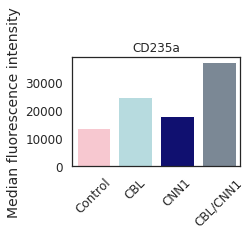

In [29]:
figure_styles()
plt.figure(figsize=[3, 2])
g = sns.barplot(x='variable', y='value', data=df, palette=hue_mapper)
g.set_xticklabels(g.get_xticklabels(), rotation=45);
plt.ylabel('Median fluorescence intensity')
plt.xlabel('')
plt.title('CD235a');
plt.savefig('./figures/K562_cDNA_CD235a.pdf', bbox_inches='tight')

In [30]:
df = pd.DataFrame(cdna_expr_data.loc['K562 CD71']).T.melt()

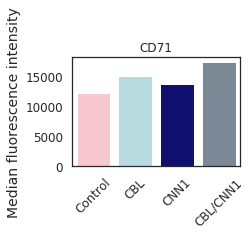

In [31]:
figure_styles()
plt.figure(figsize=[3, 2])
g = sns.barplot(x='variable', y='value', data=df, palette=hue_mapper)
g.set_xticklabels(g.get_xticklabels(), rotation=45);
plt.ylabel('Median fluorescence intensity')
plt.xlabel('')
plt.title('CD71');
plt.savefig('./figures/K562_cDNA_CD71.pdf', bbox_inches='tight')

# Scatter for model fit

This is a plot for all genes comparing the prediction from the fit to the actual expression in the doubles

0.8203773017799205


/home/tmn/.local/lib/python2.7/site-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return ((np.issubdtype(x.dtype, float) and


0.767189706603065


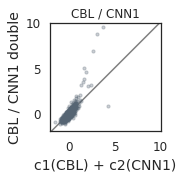

In [32]:
compare_double_to_model('CBL_CNN1', limits=[-2, 10], model_type='ts', figsize=[2,2], s=10)
plt.savefig('./figures/double_heatmap_examples_CBL_CNN1_scatter.pdf', bbox_inches='tight')

# Other examples of GIs

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 731 estimators for 2674 features...
Feature prediction accuracy (test size: 20.0%): 0.632258064516

                precision    recall  f1-score   support

    KLF1_CEBPA       0.60      0.46      0.52        52
 KLF1_NegCtrl0       0.63      0.94      0.76        51
NegCtrl0_CEBPA       0.67      0.50      0.57        52

     micro avg       0.63      0.63      0.63       155
     macro avg       0.63      0.63      0.62       155
  weighted avg       0.63      0.63      0.62       155

Picked 50 features.
Using 100 estimators for 50 features...
Feature prediction accuracy (test size: 20.0%): 0.716129032258

                precision    recall  f1-score   support

    KLF1_CEBPA       0.68      0.50      0.58        52
 KLF1_NegCtrl0       0.74      0.96      0.84        51
NegCtrl0_CEBPA       0.71      0.69      0.70        52

     micro avg       0.72      0.7

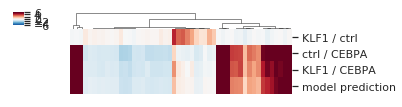

In [33]:
sns.set(font_scale=1)
_, cg = double_variable_expression_heatmap(pop,
                                           'KLF1_CEBPA',
                                           test_genes='mean > 0.5',
                                           model_fit_genes=abundant_genes,
                                           figsize=[5, 1.5],
                                           num_features=50,
                                           vmin=-6, vmax=6,
                                           additive_model=False,
                                           include_control_cells=False,
                                           include_model=True,
                                           include_difference=False,
                                           square=False)
cg.ax_heatmap.set_xticklabels([])
cg.savefig('./figures/double_heatmap_examples_KLF1_CEBPA_with_model.pdf')

0.974529864982196
0.9146704495612176


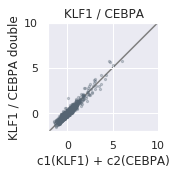

In [34]:
compare_double_to_model('KLF1_CEBPA', limits=[-2, 10], model_type='ts', figsize=[2,2])
plt.savefig('./figures/double_heatmap_examples_KLF1_CEBPA_scatter.pdf', bbox_inches='tight')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 761 estimators for 2898 features...
Feature prediction accuracy (test size: 20.0%): 0.770833333333

                 precision    recall  f1-score   support

 NegCtrl0_SNAI1       0.74      0.81      0.78        32
PTPN12_NegCtrl0       0.88      0.88      0.88        32
   PTPN12_SNAI1       0.69      0.62      0.66        32

      micro avg       0.77      0.77      0.77        96
      macro avg       0.77      0.77      0.77        96
   weighted avg       0.77      0.77      0.77        96

Picked 50 features.
Using 100 estimators for 50 features...
Feature prediction accuracy (test size: 20.0%): 0.760416666667

                 precision    recall  f1-score   support

 NegCtrl0_SNAI1       0.76      0.78      0.77        32
PTPN12_NegCtrl0       0.84      0.84      0.84        32
   PTPN12_SNAI1       0.68      0.66      0.67        32

      micro avg       0

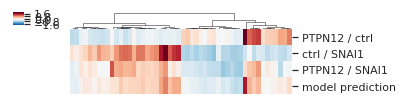

In [35]:
sns.set(font_scale=1)
_, cg = double_variable_expression_heatmap(pop,
                                           'PTPN12_SNAI1',
                                           test_genes='mean > 0.5',
                                           model_fit_genes=abundant_genes,
                                           figsize=[5, 1.5],
                                           num_features=50,
                                           vmin=-2, vmax=2,
                                           additive_model=False,
                                           include_control_cells=False,
                                           include_model=True,
                                           include_difference=False,
                                           square=False)
cg.ax_heatmap.set_xticklabels([])
cg.savefig('./figures/double_heatmap_examples_PTPN12_SNAI1_with_model.pdf')

0.8109500981747031
0.7576675279349036


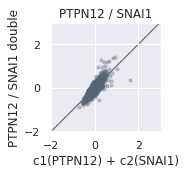

In [36]:
compare_double_to_model('PTPN12_SNAI1', limits=[-2, 3], model_type='ts', figsize=[2,2], s=10)
plt.savefig('./figures/double_heatmap_examples_PTPN12_SNAI1_scatter.pdf', bbox_inches='tight')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 725 estimators for 2630 features...
Feature prediction accuracy (test size: 20.0%): 0.891304347826

                  precision    recall  f1-score   support

     FEV_CBFA2T3       1.00      0.77      0.87        31
    FEV_NegCtrl0       0.80      0.93      0.86        30
NegCtrl0_CBFA2T3       0.91      0.97      0.94        31

       micro avg       0.89      0.89      0.89        92
       macro avg       0.90      0.89      0.89        92
    weighted avg       0.90      0.89      0.89        92

Picked 50 features.
Using 100 estimators for 50 features...
Feature prediction accuracy (test size: 20.0%): 0.869565217391

                  precision    recall  f1-score   support

     FEV_CBFA2T3       1.00      0.74      0.85        31
    FEV_NegCtrl0       0.74      0.93      0.82        30
NegCtrl0_CBFA2T3       0.94      0.94      0.94        31

       micro

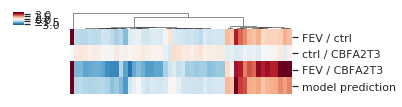

In [37]:
sns.set(font_scale=1)
_, cg = double_variable_expression_heatmap(pop,
                                           'FEV_CBFA2T3',
                                           test_genes='mean > 0.5',
                                           model_fit_genes=abundant_genes,
                                           figsize=[5, 1.5],
                                           num_features=50,
                                           vmin=-4, vmax=4,
                                           additive_model=False,
                                           include_control_cells=False,
                                           include_model=True,
                                           include_difference=False,
                                           square=False)
cg.ax_heatmap.set_xticklabels([])
cg.savefig('./figures/double_heatmap_examples_FEV_CBFA2T3_with_model.pdf')

0.8200568395010555
0.736163456953053


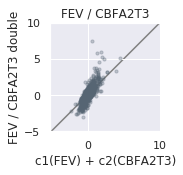

In [38]:
compare_double_to_model('FEV_CBFA2T3', limits=[-5, 10], model_type='ts', figsize=[2,2], s=10)
plt.savefig('./figures/double_heatmap_examples_FEV_CBFA2T3_scatter.pdf', bbox_inches='tight')

Generating summary statistics...
Done.
Inheriting from parent normalized matrix...
Training (genes: mean > 0.5)...
Using 764 estimators for 2919 features...
Feature prediction accuracy (test size: 20.0%): 0.35

               precision    recall  f1-score   support

NegCtrl0_STIL       0.25      0.21      0.23        14
PLK4_NegCtrl0       0.42      0.38      0.40        13
    PLK4_STIL       0.38      0.46      0.41        13

    micro avg       0.35      0.35      0.35        40
    macro avg       0.35      0.35      0.35        40
 weighted avg       0.34      0.35      0.35        40

Picked 50 features.
Using 100 estimators for 50 features...
Feature prediction accuracy (test size: 20.0%): 0.4

               precision    recall  f1-score   support

NegCtrl0_STIL       0.27      0.21      0.24        14
PLK4_NegCtrl0       0.46      0.46      0.46        13
    PLK4_STIL       0.44      0.54      0.48        13

    micro avg       0.40      0.40      0.40        40
    macro a

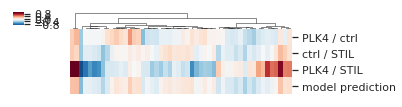

In [39]:
sns.set(font_scale=1)
_, cg = double_variable_expression_heatmap(pop,
                                           'PLK4_STIL',
                                           test_genes='mean > 0.5',
                                           model_fit_genes=abundant_genes,
                                           figsize=[5, 1.5],
                                           num_features=50,
                                           vmin=-1, vmax=1,
                                           additive_model=False,
                                           include_control_cells=False,
                                           include_model=True,
                                           include_difference=False,
                                           square=False)
cg.ax_heatmap.set_xticklabels([])
cg.savefig('./figures/double_heatmap_examples_PLK4_STIL_with_model.pdf')

0.5920787268821643
0.524852422435567


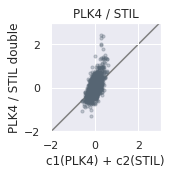

In [40]:
compare_double_to_model('PLK4_STIL', limits=[-2, 3], model_type='ts', figsize=[2,2], s=10)
plt.savefig('./figures/double_heatmap_examples_PLK4_STIL_scatter.pdf', bbox_inches='tight')